In [8]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import yaml
import random
import json
import numpy as np
from copy import copy
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs

from collections import defaultdict
from probis import *
from run import *
from analysis import *

In [3]:
with open("../cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [4]:
rep_scores = convert_intra_results_to_json(cfg)

Using cached data from convert_intra_results_to_json


In [12]:
rows = []
for (f1, f2), score in rep_scores.items():
    *rest, poc, f1 = f1.split("/")
    *rest, poc, f2 = f2.split("/")
    rows.append({
        "pocket": poc,
        "rec1": f1,
        "rec2": f2,
        "probis_score": score
    })

In [14]:
df = pd.DataFrame(rows)
df.to_csv("/home/boris/Downloads/intra_pocket_probis_scores.csv", index=False)

In [15]:
df

,pocket,rec1,rec2,probis_score
0,FABP5_HUMAN_2_135_0,4lkt_C_rec.pdb,4lkt_C_rec.pdb,3.82
1,FABP5_HUMAN_2_135_0,4lkt_C_rec.pdb,5ur9_A_rec.pdb,3.62
2,FABP5_HUMAN_2_135_0,4lkt_C_rec.pdb,1b56_A_rec.pdb,3.29
3,FABP5_HUMAN_2_135_0,4lkt_C_rec.pdb,5hz5_A_rec.pdb,3.11
4,FABP5_HUMAN_2_135_0,4lkt_C_rec.pdb,4lkp_A_rec.pdb,2.73
...,...,...,...,...
549959,JAR1_ARATH_1_575_0,5ecl_A_rec.pdb,4epl_A_rec.pdb,1.78
549960,FZD5_HUMAN_27_158_0,5urz_B_rec.pdb,5urz_B_rec.pdb,4.26
549961,FZD5_HUMAN_27_158_0,5urz_B_rec.pdb,5ury_A_rec.pdb,2.82
549962,FZD5_HUMAN_27_158_0,5ury_A_rec.pdb,5ury_A_rec.pdb,12.90


In [9]:
fam2num = get_family_to_num(cfg)

Using cached data from get_family_to_num


In [19]:
import matplotlib.pyplot as plt

In [39]:
def get_class_to_num(cfg, fam2num):
    class2num = defaultdict(int)
    for fam, num in fam2num.items():
        if "kinase" in fam:
            cls = "Kinase"
        elif "G-protein coupled receptor" in fam:
            cls = "GPCR"
        elif "cytochrome P450" in fam:
            cls = "Cytochrome P450"
        else:
            cls = "Other"
        class2num[cls] += num
    return class2num
class2num = get_class_to_num(cfg, fam2num)

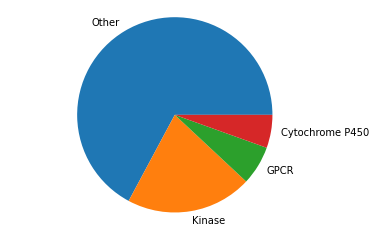

In [40]:
fig1, ax1 = plt.subplots()

ax1.pie(class2num.values(), labels=class2num.keys())
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [36]:

def get_protein_family(uniprot):
    url = f'https://rest.uniprot.org/uniprotkb/search?query=accession:{uniprot}'
    results = requests.get(url).text
    res_json = json.loads(results)
    for comment in res_json["results"][0]["comments"]:
        if "texts" not in comment: continue
        for text in comment["texts"]:
            val = text["value"]
            re_res = re.search("Belongs to the (.+) family", val)
            if re_res is not None:
                print(re_res.groups(0)[0])
get_protein_family("P14061")

short-chain dehydrogenases/reductases (SDR)


In [43]:
con = get_chembl_con(cfg)
uniprot2recs,\
uniprot2ligs,\
uniprot2pockets,\
pocket2uniprots,\
pocket2recs,\
pocket2ligs = get_uniprot_dicts(cfg)

Using cached data from get_uniprot_dicts


In [21]:
act_df = pd.read_csv(cfg["bigbind_folder"] + "/activities_val.csv")

In [22]:
max(list(enumerate(act_df.lig_smiles.str.len())), key=lambda x: x[1])

(49892, 208)

In [23]:
act_df.lig_file[49892]

'chembl_structures/mol_574657.sdf'

In [31]:
train_activities = pd.read_csv(cfg["bigbind_folder"] + "/activities_train.csv")
train_activities

,lig_smiles,lig_file,standard_type,standard_relation,standard_value,standard_units,pchembl_value,uniprot,pocket,ex_rec_file,ex_rec_pdb,ex_rec_pocket_file,num_pocket_residues,pocket_center_x,pocket_center_y,pocket_center_z,pocket_size_x,pocket_size_y,pocket_size_z
0,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,chembl_structures/mol_0.sdf,IC50,=,420.000000,nM,6.380,P14061,DHB1_HUMAN_2_290_0,DHB1_HUMAN_2_290_0/1fds_A_rec.pdb,1fds,DHB1_HUMAN_2_290_0/1fds_A_rec_pocket.pdb,52,10.424000,50.261000,24.451001,41.450000,36.186001,48.426002
1,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,chembl_structures/mol_1.sdf,IC50,=,1000.000000,nM,6.000,P14061,DHB1_HUMAN_2_290_0,DHB1_HUMAN_2_290_0/3km0_B_rec.pdb,3km0,DHB1_HUMAN_2_290_0/3km0_B_rec_pocket.pdb,68,10.424000,50.261000,24.451001,41.450000,36.186001,48.426002
2,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,chembl_structures/mol_2.sdf,IC50,=,4300.000000,nM,5.370,P14061,DHB1_HUMAN_2_290_0,DHB1_HUMAN_2_290_0/1fdw_A_rec.pdb,1fdw,DHB1_HUMAN_2_290_0/1fdw_A_rec_pocket.pdb,52,10.424000,50.261000,24.451001,41.450000,36.186001,48.426002
3,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1C[C@...,chembl_structures/mol_3.sdf,IC50,=,1150.000000,nM,5.940,P14061,DHB1_HUMAN_2_290_0,DHB1_HUMAN_2_290_0/1fdv_A_rec.pdb,1fdv,DHB1_HUMAN_2_290_0/1fdv_A_rec_pocket.pdb,74,10.424000,50.261000,24.451001,41.450000,36.186001,48.426002
4,COc1cc2[nH]c(Cc3ccccc3)cc2cc1-c1cnco1,chembl_structures/mol_5.sdf,IC50,=,600.000000,nM,6.220,P12268,IMDH2_HUMAN_1_514_0,IMDH2_HUMAN_1_514_0/1jr1_B_rec.pdb,1jr1,IMDH2_HUMAN_1_514_0/1jr1_B_rec_pocket.pdb,29,95.723499,83.240498,53.150501,18.510994,22.773003,17.443001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672769,O=C(O)c1cccc(C(=O)O)n1,chembl_structures/mol_23606.sdf,mixed,=,15135.612484,nM,4.820,Q8TDX5,ACMSD_HUMAN_1_333_0,ACMSD_HUMAN_1_333_0/4ih3_C_rec.pdb,4ih3,ACMSD_HUMAN_1_333_0/4ih3_C_rec_pocket.pdb,19,-48.954000,18.898500,-86.079002,18.296001,18.019001,15.334000
672770,O=C(O)c1cc(-c2ccc(F)cc2F)ccc1O,chembl_structures/mol_527075.sdf,mixed,=,5888.436554,nM,5.230,Q8TDX5,ACMSD_HUMAN_1_333_0,ACMSD_HUMAN_1_333_0/4ofc_C_rec.pdb,4ofc,ACMSD_HUMAN_1_333_0/4ofc_C_rec_pocket.pdb,20,-48.954000,18.898500,-86.079002,18.296001,18.019001,15.334000
672771,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,chembl_structures/mol_609763.sdf,mixed,=,467.735141,nM,6.330,P34947,GRK5_HUMAN_1_590_0,GRK5_HUMAN_1_590_0/4tnd_A_rec.pdb,4tnd,GRK5_HUMAN_1_590_0/4tnd_A_rec_pocket.pdb,33,1.986000,17.155000,-36.022499,20.598000,25.873999,22.973000
672772,Cc1[nH]c(/C=C2\C(=O)Nc3ccc(C(=O)N[C@H](C)c4ccc...,chembl_structures/mol_539526.sdf,mixed,=,30.549211,nM,7.515,P34947,GRK5_HUMAN_1_590_0,GRK5_HUMAN_1_590_0/4wnk_A_rec.pdb,4wnk,GRK5_HUMAN_1_590_0/4wnk_A_rec_pocket.pdb,32,1.986000,17.155000,-36.022499,20.598000,25.873999,22.973000


In [39]:
for targ, pockets in pcba_pockets.items():
    for pocket in pockets:
        if len(train_activities.query("pocket == @pocket")) > 0:
            print(targ, "in train")
            break
    else:
        print(targ, "not in train")

GBA in train
ALDH1 not in train
ADRB2 not in train
ESR1_ant not in train
ESR1_ago in train
FEN1 in train
KAT2A in train
PKM2 in train
MTORC1 in train
IDH1 not in train
VDR in train
PPARG in train
MAPK1 in train
OPRK1 in train
TP53 in train


In [18]:
pcba_pockets

set()

In [6]:
val_df = pd.read_csv(cfg["bigbind_folder"] + "/activities_val.csv")

In [7]:
val_df["pchembl_value"] > 5.0

0        False
1         True
2        False
3         True
4         True
         ...  
88231    False
88232    False
88233     True
88234     True
88235     True
Name: pchembl_value, Length: 88236, dtype: bool

In [8]:
df = val_df
df["active"] = df["pchembl_value"] > 5.0

In [12]:
from collections import defaultdict

poc2cluster = {}
for cluster in big_clusters:
    for pocket in cluster:
        poc2cluster[pocket] = cluster

smiles2pockets = defaultdict(set)
for i, row in tqdm(df.iterrows(), total=len(df)):
    smiles2pockets[row.lig_smiles].add(row.pocket)

100%|██████████| 88236/88236 [00:09<00:00, 8955.08it/s] 


In [21]:
lens = []
for pocket in tqdm(df.pocket.unique()):
    lens.append((pocket, len(df.query("pocket == @pocket"))))

100%|██████████| 115/115 [00:00<00:00, 293.77it/s]


In [28]:
sorted(lens, key=lambda x: x[1])

[('PRTK_PARAQ_106_384_pep_0', 1),
 ('FAB1_MYCTU_1_416_0', 1),
 ('FOLB_STAAU_1_121_0', 1),
 ('SAV_STRAV_73_165_0', 1),
 ('VGP_EBOZM_34_298_0', 1),
 ('ARS_PSEAE_1_536_0', 2),
 ('BLAC_BACLI_42_306_0', 3),
 ('HEM2_ECOLI_2_324_0', 3),
 ('GGTA1_BOVIN_80_367_0', 4),
 ('ISPD_ARATH_75_302_0', 4),
 ('NR1I3_MOUSE_114_358_0', 5),
 ('TPIS_HUMAN_38_286_0', 5),
 ('SCMU_MYCTU_34_199_0', 5),
 ('ARGI1_RAT_4_321_0', 6),
 ('VNN1_HUMAN_22_513_0', 6),
 ('CPXA_PSEPU_2_415_0', 8),
 ('RISB_MYCTU_1_160_0', 8),
 ('UPP1_HUMAN_1_310_0', 9),
 ('DNMT1_MOUSE_730_1609_0', 13),
 ('RORB_RAT_214_465_ligBind_0', 15),
 ('HAOX1_HUMAN_1_370_0', 16),
 ('RNAS1_BOVIN_42_150_0', 19),
 ('GSTA1_HUMAN_1_222_0', 20),
 ('TP53B_HUMAN_1484_1603_0', 21),
 ('PP1G_HUMAN_2_314_ligBind_0', 22),
 ('AMD_RAT_498_820_0', 23),
 ('DNPH1_RAT_9_152_0', 24),
 ('DSBA_ECOLI_20_208_0', 24),
 ('CPNS1_HUMAN_93_267_0', 25),
 ('BLAB_BACFG_18_249_0', 27),
 ('PTGIS_HUMAN_20_500_0', 29),
 ('BXA1_CLOBO_2_425_0', 29),
 ('RICI_RICCO_36_233_0', 30),
 ('1433S_HUMA

In [29]:
act = df.query("pocket == 'VGFR2_HUMAN_808_1171_0'").active
sum(act)/len(act)

0.9532177630016623

In [30]:
def make_screen_df(cfg, df, pocket, smiles2pockets, tot_len=500, max_actives=50):
    poc_df = df.query("pocket == @pocket")
    active = poc_df.query("active")
    print(len(active), len(poc_df))

for pocket in df.pocket.unique():
    make_screen_df(cfg, df, pocket, smiles2pockets)

2080 2275
1781 1991
396 401
104 115
3 3
3946 4815
21 25
423 472
903 915
6184 6441
4364 4508
153 154
3 5
7 27
134 137
1824 1837
724 1389
4 8
79 93
260 376
860 945
1675 1752
4156 4476
30 57
58 58
8028 8422
136 140
15 16
14 20
83 110
1700 1908
410 485
2460 2528
273 330
1368 1412
5902 15966
132 149
220 227
22 23
538 578
14 29
211 217
21 22
584 742
396 440
84 126
4 5
1185 1210
3507 3576
222 232
569 609
1780 1835
2969 3139
192 195
38 47
680 758
91 96
149 155
1043 1052
253 334
550 681
1 5
74 99
82 116
23 52
81 99
6 19
22 33
17 29
121 139
30 40
1 2
464 604
101 103
212 218
334 340
180 186
669 672
0 1
182 253
11 47
1 8
458 584
45 76
9 9
62 89
21 46
655 655
194 194
301 328
1 4
4 30
753 797
1 1
45 65
4 4
250 289
7 21
1 1
329 340
0 3
37 37
6 13
20 24
1 1
14 24
85 102
17 34
78 82
63 99
5 6
4 15
88 102
1 1
6 6
